In [1]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('..'))

import random
from autovar import *

def coin(p: float) -> float:
    return 1 if random.random() < p else 0

In [2]:
def high_variance():
    if coin(0.5):
        return 10
    return -10

def low_variance():
    if coin(0.5):
        return 1
    return -1

program = Profile(Mul(Sampler(NamedCallable(lambda: high_variance(), "fn1(High Variance)")), Add(Sampler(NamedCallable(lambda: low_variance(), "fn2(Low Variance)")), Exact(10))))

num_samples = 10000

print("Mean: ", Dist(program,num_samples).estimate(), "Variance: ", Dist(program.variance(),num_samples).estimate())
print("Summary:\n", program.summary())

Mean:  -0.584 Variance:  9900.22
Summary:
 ('fn1(High Variance)', 0): (30000, 1.318511553108692e-07)
('fn2(Low Variance)', 1): (30000, 1.3939836838593087e-07)
('fn1(High Variance).variance', 2): (20000, 3.330103034386411e-07)
('fn2(Low Variance).variance', 3): (20000, 3.193252225173637e-07)



In [3]:
n = 10000

# progs
no_bias_variance = Dist(program.variance(), n)
bad_bias_variance = Dist(program.variance(adaptive=True), n)
good_bias_variance = Dist(program.variance(adaptive=True), n)

# envs
opt_bias = minimize_variance(program)
bad_bias = {env_var:0.5 for env_var in opt_bias}

# record
import copy
def mean_record(x: IntractableReal, env=None) -> (float, ProfileData):
    env = env or {}
    program.clear()
    mean = x.estimate(env)
    profile_copy = copy.deepcopy(program.profile_data.data)
    return (mean, profile_copy)


# List of experiments: each is (label, variance_expr, env)
all_tasks = [
    ("No Bias", no_bias_variance, {}),
    ("Suboptimal Bias", bad_bias_variance, bad_bias),
    ("Good Bias", good_bias_variance, opt_bias),
]

results = []

for label, vexpr, env in all_tasks:
    mean, profile_copy = mean_record(vexpr,env)
    results.append((label, mean, profile_copy))

print(results)


[('No Bias', 10213.9, {('fn1(High Variance).variance', 4): [20000, 0.006808789039496332], ('fn2(Low Variance).variance', 5): [20000, 0.006460728065576404], ('fn2(Low Variance)', 1): [20000, 0.002663362887687981], ('fn1(High Variance)', 0): [20000, 0.002623465785291046]}), ('Suboptimal Bias', 9979.04, {('fn2(Low Variance).variance', 7): [3742, 0.0012366384034976363], ('fn1(High Variance)', 0): [4918, 0.0006668383721262217], ('fn1(High Variance).variance', 6): [7541, 0.0025543985539115965], ('fn2(Low Variance)', 1): [4912, 0.0006594927399419248]}), ('Good Bias', 9890.12911286954, {('fn1(High Variance).variance', 8): [9803, 0.0033590433886274695], ('fn2(Low Variance)', 1): [19180, 0.0024982563918456435], ('fn2(Low Variance).variance', 9): [398, 0.00013318267883732915], ('fn1(High Variance)', 0): [394, 5.141174187883735e-05]})]


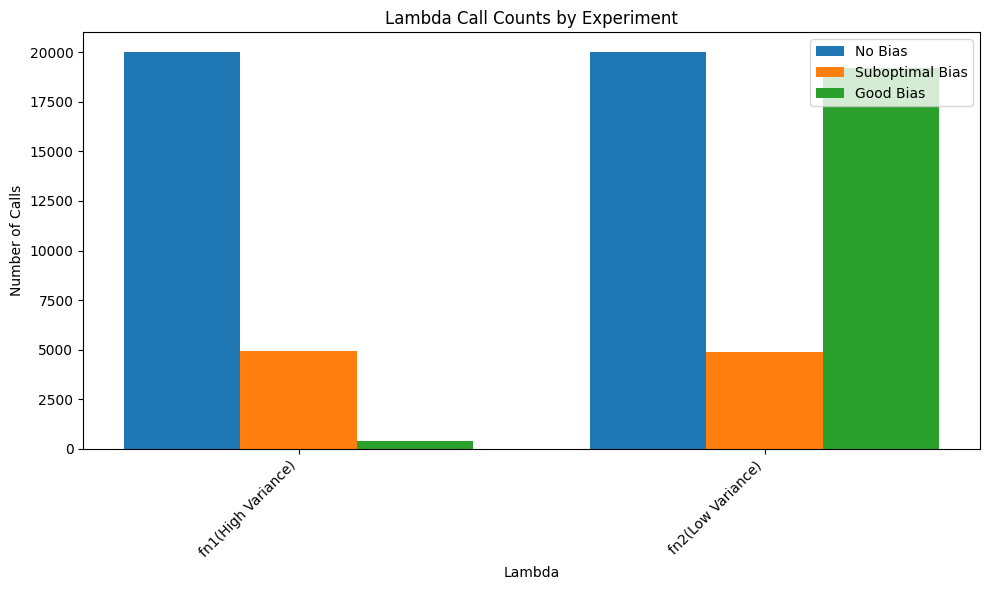

In [4]:
# Plot
import numpy as np
import matplotlib.pyplot as plt

# Extract lambda names, filtering out those ending with '.variance'
# These are proportional to original calls and are distracting for plot - WP

lambda_names = sorted(
    set(
        name
        for _, _, prof in results
        for (name, _) in prof.keys()
        if not name.endswith(".variance")
    )
)

# Build count data for each experiment
counts_by_task = {}
for label, mean, prof in results:
    counts_by_task[label] = {name: 0 for name in lambda_names}
    for (name, uid), (count, time) in prof.items():
        if name in lambda_names:
            counts_by_task[label][name] = count

# Create grouped bar chart
x = np.arange(len(lambda_names))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))

for i, (label, _, _) in enumerate(results):
    counts = [counts_by_task[label][name] for name in lambda_names]
    offset = (i - 1) * width  # Centers the 3 bars around each x position
    ax.bar(x + offset, counts, width, label=label)

ax.set_xlabel('Lambda')
ax.set_ylabel('Number of Calls')
ax.set_title('Lambda Call Counts by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(lambda_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()
